In [1]:
%matplotlib inline
import pandas as pd
from moda.dataprep import raw_to_ts, ts_to_range

In [2]:
DATAPATH = "moda/example/SF_data/SF311-2008.csv"
# The dataset can be downloaded from here: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data
TIME_RANGE = "3H" # Aggregate all events in the raw data into 3 hour intervals

# Read raw file
raw = pd.read_csv(DATAPATH,nrows=100000)
raw = raw.rename(columns={'Opened':'date','Category':'category'})

# Turn the raw data into a time series (with date as a pandas DatetimeIndex)
ts = raw_to_ts(raw)

# Aggregate items per time and category, given a time interval
ranged_ts = ts_to_range(ts,time_range=TIME_RANGE)

In [3]:
raw.head()

,category,Request Details,timestamp
date,,,
2008-07-02 15:16:55,Tree Maintenance,Lifted_sidewalk_tree_roots,1215011815
2008-07-02 16:47:08,Tree Maintenance,Hanging_limb,1215017228
2008-07-02 17:54:07,Tree Maintenance,Blocking_street_lights,1215021247
2008-07-03 12:38:04,Tree Maintenance,Sprinkler_system_issues,1215088684
2008-07-03 12:44:26,Street and Sidewalk Cleaning,Other Loose Garbage,1215089066


In [4]:
ranged_ts.head()

value
date                category                           
2008-07-01 00:00:00 Abandoned Vehicle               1.0
                    Street and Sidewalk Cleaning    2.0
                    Tree Maintenance                1.0
2008-07-01 03:00:00 311 External Request            1.0
                    Abandoned Vehicle               0.0

In [5]:
from moda.evaluators import get_metrics_for_all_categories, get_final_metrics
from moda.dataprep import read_data
from moda.models import STLTrendinessDetector

dataset = read_data("moda/datasets/SF24H_labeled.csv") ## Labeled data
print(dataset.head())

num_categories = len(dataset.index.get_level_values(1).unique())

print("\n******\n")
model = STLTrendinessDetector(freq='24H', 
                              min_value=10,
                              anomaly_type='residual',
                              num_of_std=3, lo_delta=0)

print("\n******\n")
print("Running STL model on {} categories...".format(num_categories))

# Take the entire time series and evaluate anomalies on all of it or just the last window(s)
prediction = model.predict(dataset)
raw_metrics = get_metrics_for_all_categories(dataset[['value']], prediction[['prediction']], dataset[['label']],
                                             window_size_for_metrics=1)
metrics = get_final_metrics(raw_metrics)
print("\n******\n")
print("Finished evaluating all {} categories. Metrics values across all categories:".format(num_categories))
print('f1 = {}'.format(metrics['f1']))
print('precision = {}'.format(metrics['precision']))
print('recall = {}'.format(metrics['recall']))


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Read 8661 rows
                                       Unnamed: 0  value  label
date       category                                            
2018-01-01 Abandoned Vehicle                    0     52      0
           Blocked Street or SideWalk           1     14      0
           Catch Basin Maintenance              2      1      0
           Color Curb                           3      2      0
           Damaged Property                     4     18      0

******

STL Initialized with this params:
freq = 24H
is_multicategory = True
lo_delta = 0
lo_frac = 0.6
num_of_std = 3
seasonality = 7
min_value = 10
anomaly_type = residual
resample = True
min_periods = 10
lookback = 30D

******

Running STL model on 84 categories...

******

Finished evaluating all 84 categories. Metrics values across all categories:
f1 = 0.6290322580645161
precision = 0.6964285714285714
recall = 0.5735294117647058


Plotting STL results for category Noise Report


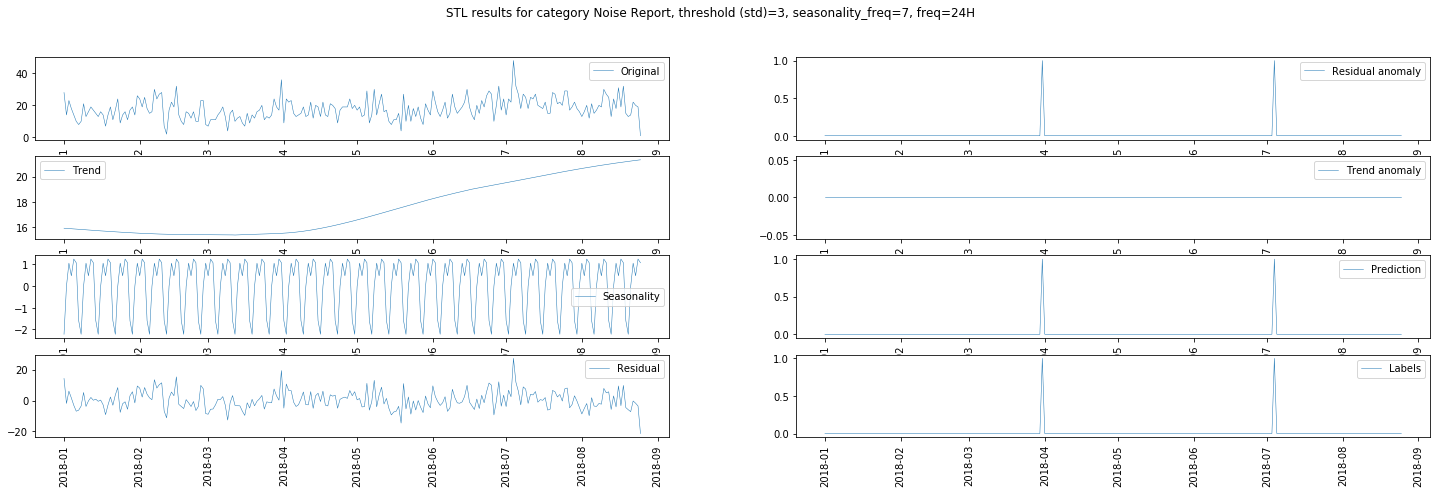

In [15]:
## Plot results for one category
import matplotlib.pyplot as plt
category = "Noise Report"

fig = plt.figure(figsize=(25,7))
model.plot(labels = dataset[['label']],savefig=False,specific_category=category)
#plt.savefig("figs/STL_example.png",bbox_inches='tight')